In [186]:
# montecarlo_integration.py
"""Volume 1: Monte Carlo Integration.
Nathan Schill
Section 2
Tues. Feb. 21, 2023
"""

import numpy as np
from scipy import linalg as la
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
# Problem 1
def ball_volume(n, N=10000):
    """Estimate the volume of the n-dimensional unit ball.

    Parameters:
        n (int): The dimension of the ball. n=2 corresponds to the unit circle,
            n=3 corresponds to the unit sphere, and so on.
        N (int): The number of random points to sample.

    Returns:
        (float): An estimate for the volume of the n-dimensional unit ball.
    """

    # Get N points from n-interval [-1, 1] x ... x [-1, 1] in R^n
    points = np.random.uniform(-1, 1, (n, N))

    # Get distances from origin
    lengths = la.norm(points, axis=0)

    # Count points within unit ball
    num_within = np.count_nonzero(lengths < 1)

    # Multiply percentage of points within unit ball by volume
    # of n-interval used in uniform distribution above
    return 2**n * (num_within/N)
    
ball_volume(2)

3.1488

In [4]:
# Problem 2
def mc_integrate1d(f, a, b, N=10000):
    """Approximate the integral of f on the interval [a,b].

    Parameters:
        f (function): the function to integrate. Accepts and returns scalars.
        a (float): the lower bound of interval of integration.
        b (float): the lower bound of interval of integration.
        N (int): The number of random points to sample.

    Returns:
        (float): An approximation of the integral of f over [a,b].

    Example:
        >>> f = lambda x: x**2
        >>> mc_integrate1d(f, -4, 2)    # Integrate from -4 to 2.
        23.734810301138324              # The true value is 24.
    """
    
    # Sample N random points from [a, b]
    pts = np.random.uniform(a, b, size=N)

    # Get V(omega)
    vol = b-a

    # Use equation (11.2) from lab PDF
    return vol*np.mean(f(pts))


f = lambda x: np.abs(np.sin(10*x)*np.cos(10*x) + x**(1/2) * np.sin(3*x))
mc_integrate1d(lambda x: x**2, -4, 2), mc_integrate1d(lambda x: np.sin(x), -2*np.pi, 2*np.pi),\
mc_integrate1d(lambda x: 1/x, 1, 10), mc_integrate1d(f, 1, 5), 

(24.043750962204598,
 -0.11772501732127713,
 2.3060472719997662,
 4.491477200798263)

In [183]:
# Problem 3
def mc_integrate(f, mins, maxs, N=10000):
    """Approximate the integral of f over the box defined by mins and maxs.

    Parameters:
        f (function): The function to integrate. Accepts and returns
            1-D NumPy arrays of length n.
        mins (list): the lower bounds of integration.
        maxs (list): the upper bounds of integration.
        N (int): The number of random points to sample.

    Returns:
        (float): An approximation of the integral of f over the domain.

    Example:
        # Define f(x,y) = 3x - 4y + y^2. Inputs are grouped into an array.
        >>> f = lambda x: 3*x[0] - 4*x[1] + x[1]**2

        # Integrate over the box [1,3]x[-2,1].
        >>> mc_integrate(f, [1, -2], [3, 1])
        53.562651072181225              # The true value is 54.
    """

    # Number of dimensions
    n = len(mins)

    # Change to ndarrays; get V(omega)
    mins, maxs = np.array(mins), np.array(maxs)
    vol = np.prod(maxs-mins)
    
    # Sample pts from standard uniform distribution in n dimensions, then scale and shift
    pts = np.random.uniform(size=(n, N)).T
    pts = (pts * (maxs-mins) + mins).T
    
    # Each column is a point

    # Use equation (11.1) from lab PDF
    return vol * np.mean(f(pts))


def f(t):
    x, y = t
    return x**2 + y**2
def g(t):
    x, y = t
    return 3*x - 4*y + y**2
def h(t):
    x, y, z, w = t
    return x + y - w*z**2

# mc_integrate(f, [0,0], [1,1]), mc_integrate(g, [1, -2], [3, 1]),\
# mc_integrate(h, [-1, -2, -3, -4], [1, 2, 3, 4])

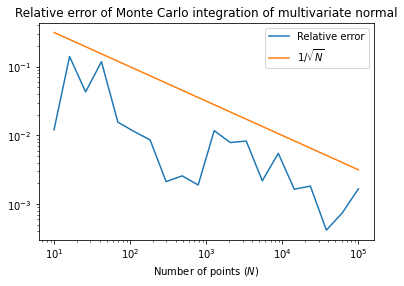

In [205]:
# Problem 4
def prob4():
    """Let n=4 and Omega = [-3/2,3/4]x[0,1]x[0,1/2]x[0,1].
    - Define the joint distribution f of n standard normal random variables.
    - Use SciPy to integrate f over Omega.
    - Get 20 integer values of N that are roughly logarithmically spaced from
        10**1 to 10**5. For each value of N, use mc_integrate() to compute
        estimates of the integral of f over Omega with N samples. Compute the
        relative error of estimate.
    - Plot the relative error against the sample size N on a log-log scale.
        Also plot the line 1 / sqrt(N) for comparison.
    """
    
    # Define the bounds of integration
    mins = np.array([-3/2, 0, 0, 0])
    maxs = np.array([3/4, 1, 1/2, 1])

    ### Get the "exact" value of the integral with SciPy
    # The distribution has mean 0 and covariance I (the nxn identity)
    means, cov = np.zeros(4), np.eye(4)
    # Compute the integral with SciPy
    F = stats.mvn.mvnun(mins, maxs, means, cov)[0]

    def f(x):
        '''x in R^4'''
        n = 4
        
        # If x is a single point
        if len(x.shape) == 1:
            inner_prod = np.dot(x, x)
        
        # Elif x is an array of points
        elif len(x.shape) == 2:
            # Each column is a point, so transpose to get each point as a row
            inner_prod = np.array([np.dot(t, t) for t in x.T])
        
        return np.exp(-inner_prod/2) / (2*np.pi)**(n/2)

    # Get 20 integers log spaced between 10^1 = 1e1 and 10^5 = 1e5
    N = np.logspace(1, 5, 20).astype(int)

    # Estimate integral of f over domain with the n points for each n in N
    estimates = np.array([mc_integrate(f, mins, maxs, n) for n in N])
    
    # Get relative error for each estimate
    rel_error = np.abs((estimates - F)/F)

    # Plot
    plt.loglog(N, rel_error, label='Relative error')
    plt.loglog(N, 1/(N)**(1/2), label='$1/\sqrt{N}$')

    # Plot properties
    plt.legend()
    plt.title('Relative error of Monte Carlo integration of multivariate normal')
    plt.xlabel('Number of points ($N$)')
    plt.show()


prob4()